In [3]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from numpy import clip
from torch.autograd import Variable
import torch
from torch import Tensor
from torch.optim import SGD, Adam
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact
from torch.nn.functional import softplus
w = widgets.IntText()
%matplotlib inline
%run utils.py
%load_ext Cython
from numpy.random import permutation
M, N = 20, 70

def log_sum_exp(value):
    m = torch.max(value)
    sum_exp = torch.sum(torch.exp(value - m))
    return m + torch.log(sum_exp)

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [4]:
%%cython 
import numpy as np
cimport numpy as np

cdef int M = 20
cdef int N = 70
DTYPE = int
ctypedef np.int_t DTYPE_t


def random_path(int sx, int sy, int tx, int ty, int L):
    """sample L random paths from sx, sy to tx, ty"""
    cdef int hor_dir, ver_dir, X, Y, XY
    
    hor_dir = (tx - sx) > 0
    ver_dir = (ty - sy) > 0
    
    cdef np.ndarray[DTYPE_t, ndim=3] paths = np.zeros([M, N, L], dtype=DTYPE)
    paths[sx,sy,:] = 1
    
    X = abs(tx - sx) 
    Y = abs(ty - sy) 
    XY = X + Y
    
    cdef np.ndarray[DTYPE_t, ndim=1] path = np.zeros(X+Y, dtype=DTYPE)
    path[:X] = 1
    
    cdef int l, i, x, y

    for l in range(L):
        x, y = sx, sy
        np.random.shuffle(path)
        for i in range(XY):
            if path[i]:
                x += 2 * hor_dir - 1
            else:
                y += 2 * ver_dir - 1
            paths[x,y,l] = 1
    return paths

In [ ]:
# hyperparameters of the model
L = 20
s2 = 10 ** 2 # sigma2 = (10 s) ** 2

for hour in [4, 8, 12, 18]:
    # file to run model on
    filename = 'data/split/JC_week1_hour{}_40x140.csv'.format(hour)
    df = pd.read_csv(filename)
    df[['sx', 'sy','tx','ty']] = df[['sx', 'sy','tx','ty']] // 2
    weights = Variable((15 * torch.ones((M,N))).float(), requires_grad=True)
    optimizer = Adam([weights], lr = 0.005)
    num_epochs = int(500000//len(df))
    print(hour, num_epochs)
    def loss_fn(paths, t):
        """Implement the loss function"""
        weighted_paths = (Variable(Tensor(paths.astype(float)))
                                  * weights.unsqueeze(-1))
        weight_sums = weighted_paths.sum(dim=0).sum(dim=0)
        first = (-1/(2 * L * s2) * (t - weight_sums).pow(2).sum())
        second = - weighted_paths.sum() / L
        third = - log_sum_exp(-weight_sums)
        loss = -(first + second + third)
        return loss 
    pbar = tqdm(total=num_epochs * len(df))
    losses = []
    for epoch in range(num_epochs):
        for _, duration, sx, sy, tx, ty in (df.sample(frac=1).itertuples()):
            pbar.update(1)
            paths = random_path(int(sx), int(sy), 
                                int(tx), int(ty), L)
            t = float(duration)
            loss = loss_fn(paths, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
    np.save('results/weights_week1hour{}_f.npy'.format(hour), weights.data.numpy())
    np.save('results/losses_week1hour{}_f.npy'.format(hour), np.array(losses))

4 131


A Jupyter Widget


8 6


A Jupyter Widget


12 8


A Jupyter Widget

The loss function is $$
\sum_{k=1}^N\left\{-\frac{1}{2L\sigma^2}\sum_{j=1}^L \left(T^{(k)} - \sum_{\text{path}_j} w_i\right) - \frac{1}{L} \sum_{j=1}^L \sum_{\text{path}} w_i - \text{logsumexp}\left(-\sum_{\text{path}_j}w_i\right)\right\} + \log p(W).
$$

We tentatively ignore the prior on $W$.

In [1]:
# df = pd.read_csv(filename)
optimizer = Adam([weights], lr = 0.01) # using Adam since we are doing some stochastic optimization things
num_epochs = 
def loss_fn(paths, t):
    """Implement the loss function"""
    weighted_paths = (Variable(Tensor(paths.astype(float)))
                              * weights.unsqueeze(-1))
    weight_sums = weighted_paths.sum(dim=0).sum(dim=0)
    first = (-1/(2 * L * s2) * (t - weight_sums).pow(2).sum())
    second = - weighted_paths.sum() / L
    third = - log_sum_exp(-weight_sums)
    loss = -(first + second + third)
    return loss 

pbar = tqdm(total=num_epochs * len(df))
losses = []
for epoch in range(num_epochs):
    for _, duration, sx, sy, tx, ty in (df.sample(frac=1).itertuples()):
        pbar.update(1)
        paths = random_path(int(sx), int(sy), 
                            int(tx), int(ty), L)
        t = float(duration)
        loss = loss_fn(paths, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        
np.save('results/weights_week1hour{}_f.npy', weights.data.numpy())
np.save('results/losses_week1hour{}_f.npy', np.array(losses))

NameError: name 'Adam' is not defined

In [45]:
# for epoch in range(num_epochs):
#     for _, duration, sx, sy, tx, ty in (df.sample(frac=1).itertuples()):
#         pbar.update(1)
#         paths = random_path(int(sx), int(sy), 
#                             int(tx), int(ty), L)
#         t = float(duration)
#         loss = loss_fn(paths, t)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.data[0])

In [5]:
np.save('results/weights_week1hour4_1.npy', weights.data.numpy())
np.save('results/losses_week1hour4_1.npy', np.array(losses))

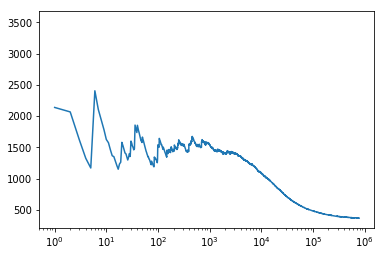

In [46]:
plt.plot(np.array(losses).cumsum()/np.arange(1,len(losses)+1))
plt.xscale('log')


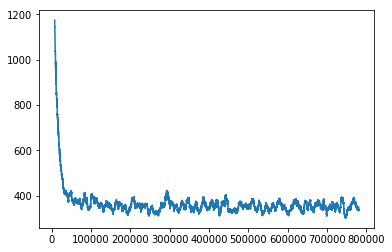

In [50]:
plt.plot((pd.Series(losses).rolling(len(df)//10).mean()))

In [ ]:
plt.imshow()

In [30]:
np.convolve(np.array(losses), np.ones((N,))/N, mode='valid')

array([ 311.29456444])

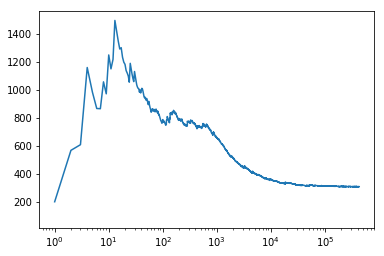

In [36]:
# cumsum / arange
plt.plot(np.array(losses).cumsum()/np.arange(1,len(losses)+1))
plt.xscale('log')
#plt.yscale('log')

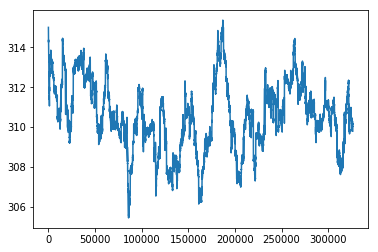

In [35]:
# running average via convolution
N = 100000
plt.plot(
    np.convolve(np.array(losses), np.ones((N,))/N, mode='valid'))
# # plt.xscale('log')
# #plt.yscale('log')
# plt.xlim((10000,len(losses)))

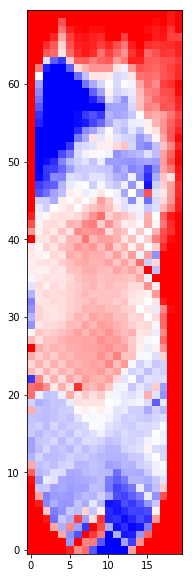

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(softplus(weights).data.numpy().T, origin='lower',
           clim=(20,70),cmap='bwr')


In [64]:
np.save('results/losses_week1hour8_4.npy', arr=np.array(losses))

In [59]:
weights

Variable containing:
  80.0000   80.0000   80.0000  ...    80.0000   80.0000   80.0000
  80.0000   80.0000   80.0000  ...    80.0000   80.0000   80.0000
  80.3176   80.3176   80.9529  ...    79.6824   80.0000   80.0000
             ...                ⋱                ...             
  80.0000   80.0000   79.6824  ...    68.5620   73.0259   73.5459
  80.0000   80.0000   80.0000  ...    64.7392   67.5195   67.4749
  80.0000   80.0000   80.0000  ...    85.2549   90.1408   76.4488
[torch.FloatTensor of size 20x70]